In [60]:
import numpy as np
import pandas as pd
import glob
import random

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import SqrtStretch, ZScaleInterval, SinhStretch, AsinhStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from photutils.aperture import CircularAperture
from photutils.centroids import centroid_1dg, centroid_2dg

In [2]:
def median_frames(folder, filenames):

    cube = np.zeros((len(filenames), 1024, 1056))

    for i, f in enumerate(filenames):

        hdul = fits.open(f'{folder}/{f}.fits')
        cube[i, :, :] = hdul[0].data
        hdul.close()

    cube_med = np.median(cube, axis=0)

    return cube_med

def mean_frames(folder, filenames):

    cube = np.zeros((len(filenames), 1024, 1056))

    for i, f in enumerate(filenames):

        hdul = fits.open(f'{folder}/{f}.fits')
        cube[i, :, :] = hdul[0].data
        hdul.close()

    cube_med = np.average(cube, axis=0)

    return cube_med

In [3]:
folder = '/Users/isabelkain/Desktop/pluto-2021-09-**'
filelist = glob.glob(f'{folder}/*.fits')

In [4]:
## List of filenames

fnames = np.array([])
fpaths = np.array([])

for f in filelist:
    txt = f.split('/')[-1].split('.')[0]  # reduce full path to just file name (w/out extension)
    fnames = np.append(fnames, txt)
    fpaths = np.append(fpaths, f[:-11])

## List of filetypes (e.g. bias, flat, science, etc)

ftypes = np.array([])

for f in filelist:

    hdul = fits.open(f)
    tag = hdul[0].header['OBJECT']
    hdul.close()

    ftypes = np.append(ftypes, tag)

## Zip filenames and types into pandas DF

filedict = pd.DataFrame(np.array([fpaths, fnames, ftypes]).T, columns=['Path', 'Filename', 'Target'])
filedict.sort_values(by='Filename', inplace=True, ignore_index=True)
filedict

,Path,Filename,Target
0,/Users/isabelkain/Desktop/pluto-2021-09-19,d1071,bias
1,/Users/isabelkain/Desktop/pluto-2021-09-19,d1072,bias
2,/Users/isabelkain/Desktop/pluto-2021-09-19,d1073,bias
3,/Users/isabelkain/Desktop/pluto-2021-09-19,d1074,bias
4,/Users/isabelkain/Desktop/pluto-2021-09-19,d1075,bias
5,/Users/isabelkain/Desktop/pluto-2021-09-19,d1076,dark
6,/Users/isabelkain/Desktop/pluto-2021-09-19,d1077,dark
7,/Users/isabelkain/Desktop/pluto-2021-09-19,d1078,dark
8,/Users/isabelkain/Desktop/pluto-2021-09-19,d1079,dark
9,/Users/isabelkain/Desktop/pluto-2021-09-19,d1080,dark


# Night 1 analysis

## Bias

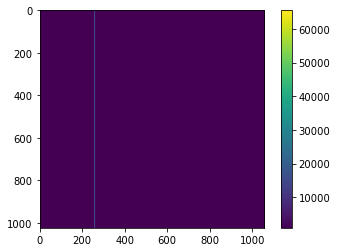

In [5]:
## Look at bias

cond = (filedict['Target']=='bias') & (filedict['Path'].str.contains('2021-09-19'))
bias_fnames = filedict[cond]['Filename'].array
bias_med = median_frames(filedict[cond]['Path'].array[0], bias_fnames)

plt.imshow(bias_med)
plt.colorbar()   

1024


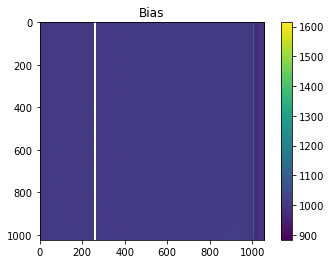

In [6]:
## Mask bad column

colmask = bias_med>10000
plt.imshow(np.ma.array(data=bias_med, mask=colmask))
plt.colorbar()
plt.title('Bias')

print(np.sum(colmask))

## Darks

Text(0.5, 1.0, 'Darks (bias-subtracted)')

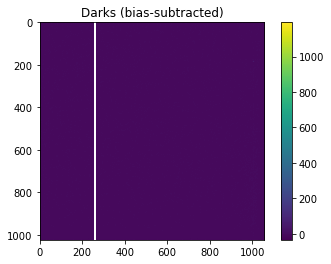

In [7]:
cond = (filedict['Target']=='dark') & (filedict['Path'].str.contains('2021-09-19'))
darks_fnames = filedict[cond]['Filename'].array
darks_med = median_frames(filedict[cond]['Path'].array[0], darks_fnames) 

plt.imshow(np.ma.array(data=darks_med-bias_med, mask=colmask))
plt.colorbar()
plt.title('Darks (bias-subtracted)')

1009.0
1007.0


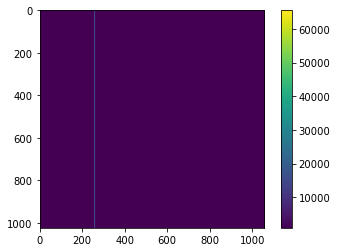

In [8]:
print(np.median(bias_med))
print(np.median(darks_med))

plt.imshow(bias_med)
plt.colorbar()

## Dome flats

Text(0.5, 1.0, 'Dome flats')

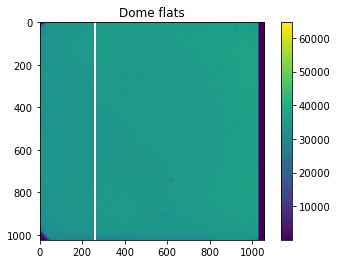

In [9]:
cond = (filedict['Target']=='flat') & (filedict['Path'].str.contains('2021-09-19'))
domeflats_fnames = filedict[cond]['Filename'].array
dflats_med = median_frames(filedict[cond]['Path'].array[0], domeflats_fnames)

plt.imshow(np.ma.array(data=dflats_med-darks_med, mask=colmask))
plt.colorbar()
plt.title('Dome flats')

## Sky flats

Text(0.5, 1.0, 'Sky flats')

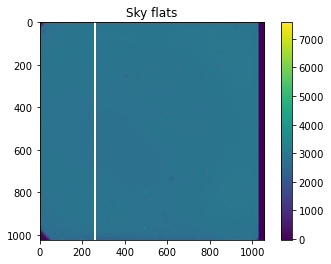

In [10]:
## Look at sky flats

cond = (filedict['Target']=='sky_flatI') & (filedict['Path'].str.contains('2021-09-19'))
skyflats_fnames = filedict[cond]['Filename'].array
skyflats_med = mean_frames(filedict[cond]['Path'].array[0], skyflats_fnames)

plt.imshow(np.ma.array(data=skyflats_med-darks_med, mask=colmask))
plt.colorbar()
plt.title('Sky flats')

## Flats choice

In [11]:
print(np.std(dflats_med))
print(np.std(skyflats_med))

## Sky flats have lower STD, probably a more uniform illumination

6409.488913319619
1966.7914976331758


## Science median

3
(10, 1024, 1056)
(7, 1024, 1056)
37448.57142857143 765.8571428571429 796.168221213601


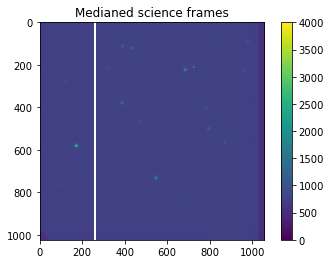

In [12]:
## Science

cond = (filedict['Target']=='science_pluto') & (filedict['Path'].str.contains('2021-09-19'))
science_fnames = filedict[cond]['Filename'].array
scpath = filedict[cond]['Path'].array[0]
                           
pluto = np.zeros((len(science_fnames), 1024, 1056))
rmcount = 0

for i, sc in enumerate(science_fnames):
    
    shdul = fits.open(f'{scpath}/{sc}.fits')
    itime = shdul[0].header['EXPTIME']
    
    if itime != 30:
        shdul.close()
        rmcount += 1
        i -= 1
        continue # skip integration times of !=30 seconds
    
    pluto[i,:,:] = shdul[0].data
    shdul.close()
    
print(rmcount)
print(np.shape(pluto))
pluto = pluto[:len(science_fnames)-rmcount]
print(np.shape(pluto))

pluto_med = np.average(pluto, axis=0)

plt.imshow(np.ma.array(data=pluto_med, mask=colmask), vmin=0, vmax=4000)
plt.colorbar()
plt.title('Medianed science frames')
print(pluto_med.max(), np.median(pluto_med), np.average(pluto_med))

## Final science reduction

Text(0.5, 1.0, 'Calibrated science')

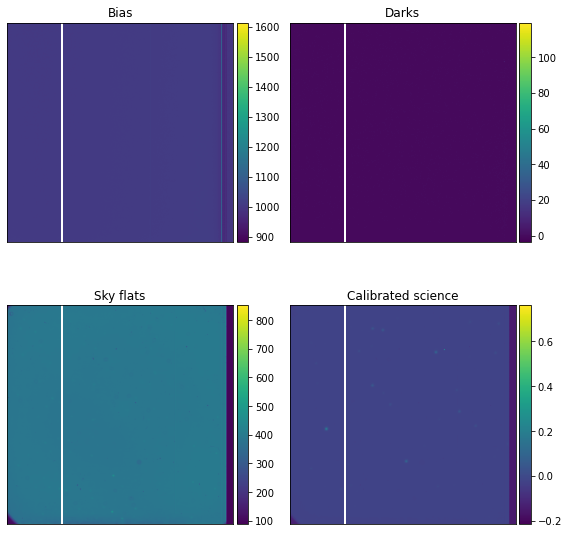

In [13]:
## Final image creation

bias = bias_med
dark = (darks_med - bias) / 10.
flat = (skyflats_med - dark) / 10.

science = (((pluto_med - bias) / 30.) - dark) / flat

## Plot

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plt.tight_layout()

im1 = ax[0][0].imshow(np.ma.array(data=bias, mask=colmask))
im2 = ax[0][1].imshow(np.ma.array(data=dark, mask=colmask))
im3 = ax[1][0].imshow(np.ma.array(data=flat, mask=colmask))
im4 = ax[1][1].imshow(np.ma.array(data=science, mask=colmask))

divider = make_axes_locatable(ax[0][0])
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

divider = make_axes_locatable(ax[0][1])
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')

divider = make_axes_locatable(ax[1][0])
cax3 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')

divider = make_axes_locatable(ax[1][1])
cax4 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax4, orientation='vertical')

ax[0][0].tick_params(left=False, bottom=False) 
ax[0][1].tick_params(left=False, bottom=False) 
ax[1][0].tick_params(left=False, bottom=False) 
ax[1][1].tick_params(left=False, bottom=False) 

ax[0][0].set(yticklabels=[], xticklabels=[]) 
ax[0][1].set(yticklabels=[], xticklabels=[]) 
ax[1][0].set(yticklabels=[], xticklabels=[]) 
ax[1][1].set(yticklabels=[], xticklabels=[]) 

ax[0][0].set_title('Bias')
ax[0][1].set_title('Darks')
ax[1][0].set_title('Sky flats')
ax[1][1].set_title('Calibrated science')

In [14]:
hdu = fits.PrimaryHDU(flat)
hdu.writeto('flats.fits', overwrite=True)

## Save final science image


19h45m06.33s -22d54m43.8s


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (296.276375, -22.91216667)>

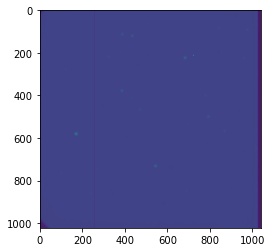

In [15]:
## Extract sky coords from Nickel image

cond = (filedict['Target']=='science_pluto') & (filedict['Path'].str.contains('2021-09-19'))
scpath = filedict[cond]['Path'].array[0]
scfile = filedict[cond]['Filename'].array[-1]
nhdu = fits.open(f'{scpath}/{scfile}.fits')[0]

wcs = WCS(nhdu.header)
frame = nhdu.header['RADESYSS'].lower()
dec = list(nhdu.header['DEC'])
ra = list(nhdu.header['RA'])

# Reformat RA

count = 0

for i in range(len(ra)):

    if ra[i] == ':':

        if count == 0:
            ra[i] = 'h'
        if count == 1:
            ra[i] = 'm'

        count += 1

ra = "".join(ra) + 's'


# Reformat DEC

count = 0

for i in range(len(dec)):

    if dec[i] == ':':

        if count == 0:
            dec[i] = 'd'
        if count == 1:
            dec[i] = 'm'

        count += 1

dec = "".join(dec) + 's'

print(ra, dec)


## Create SkyCoord object, paste it to calibrated image

position = SkyCoord(f'{ra} {dec}', frame=frame)
display(position)

cutout = Cutout2D(science, position=position, size=np.shape(science), wcs=wcs)

plt.imshow(cutout.data)


## Save calibrated image with sky coords

hdu = fits.PrimaryHDU(cutout.data)
hdu.header.update(cutout.wcs.to_header())

hdul = fits.HDUList([hdu])
hdul.writeto('calibrated_pluto_night1.fits', overwrite=True)


# Night 2 analysis

In [16]:
## Calibration images -- oops we didn't take any, recycling from prev. night

# n2_bias_filenames = np.array(filedict[filedict['Target']=='XXXX']['Filename'])
# n2_darks_filenames = np.array(filedict[filedict['Target']=='XXXX']['Filename'])
# n2_domeflats_filenames = np.array(filedict[filedict['Target']=='XXXX']['Filename'])
# n2_skyflats_filenames = np.array(filedict[filedict['Target']=='XXXX']['Filename'])

# n2_bias_med = median_frames(folder, n2_bias_filenames)
# n2_colmask = n2_bias_med > 10000
# n2_darks_med = median_frames(folder, n2_darks_filenames)
# n2_domeflats_med = median_frames(folder, n2_domeflats_filenames)
# n2_skyflats_med = median_frames(folder, n2_skyflats_filenames)


Text(0.5, 1.0, 'Medianed Pluto image, night 2')

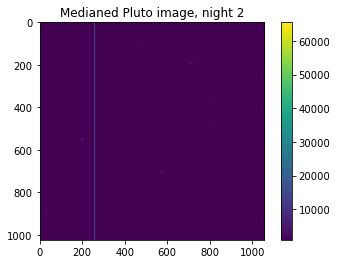

In [17]:
## Combine science images

cond = (filedict['Target']=='science_pluto') & (filedict['Path'].str.contains('2021-09-20'))
n2_science_filenames = filedict[cond]['Filename'].array[:-1] # last frame was cut short, exclude
n2_pluto_med = median_frames(filedict[cond]['Path'].array[0], n2_science_filenames)

plt.imshow(n2_pluto_med)
plt.colorbar()
plt.title('Medianed Pluto image, night 2')

1024


Text(0.5, 1.0, 'Bad column mask')

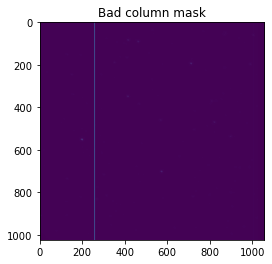

In [18]:
n2_colmask = bias > 10000.

print(np.sum(n2_colmask))

plt.imshow(n2_pluto_med)
plt.title('Bad column mask')

Text(0.5, 1.0, 'Calibrated science')

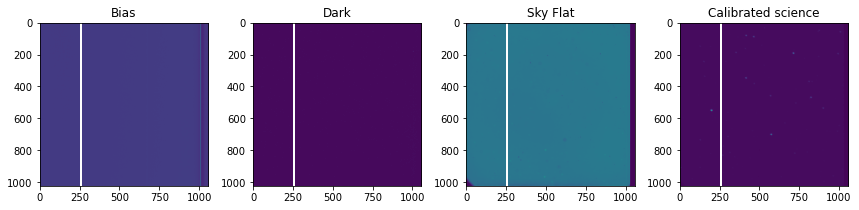

In [19]:
## Image calibration

## no calibration data taken for Night 2
science2 = (((n2_pluto_med - bias) / 30.) - dark) / flat  ## OBSERVATION ITIME

# bias = bias_med
# dark = (darks_med - bias) / 10.
# flat = (skyflats_med - dark) / 10.
# science = (((pluto_med - bias) / 30.) - dark) / flat



## Display results (with column mask)

fig, ax = plt.subplots(1,4,figsize=(12,5))
plt.tight_layout()

ax[0].imshow(np.ma.array(data=bias, mask=n2_colmask))
ax[1].imshow(np.ma.array(data=dark, mask=n2_colmask))
ax[2].imshow(np.ma.array(data=flat, mask=n2_colmask))
ax[3].imshow(np.ma.array(data=science2, mask=n2_colmask))

ax[0].set_title('Bias')
ax[1].set_title('Dark')
ax[2].set_title('Sky Flat')
ax[3].set_title('Calibrated science')

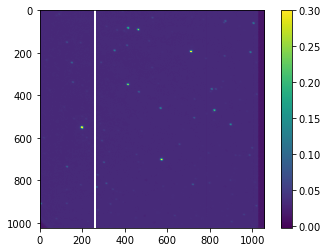

In [20]:
## Plot final image prettily

norm = ImageNormalize(interval=ZScaleInterval(contrast=0.9), stretch=AsinhStretch()) 

plt.imshow(np.ma.array(data=science2, mask=n2_colmask), vmax=0.3)
plt.colorbar()

/Users/isabelkain/Desktop/pluto-2021-09-20 d2098
                                          Path Filename         Target
31  /Users/isabelkain/Desktop/pluto-2021-09-20    d2095  science_pluto
32  /Users/isabelkain/Desktop/pluto-2021-09-20    d2096  science_pluto
33  /Users/isabelkain/Desktop/pluto-2021-09-20    d2097  science_pluto
34  /Users/isabelkain/Desktop/pluto-2021-09-20    d2098  science_pluto
19h45m06.34s -22d54m43.9s


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (296.27641667, -22.91219444)>

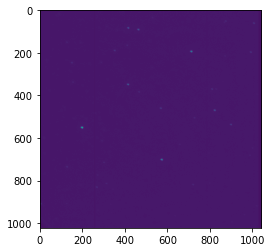

In [21]:
## Get coordinates from Nickel image and save final calibrated science image

cond = (filedict['Target']=='science_pluto') & (filedict['Path'].str.contains('2021-09-20'))
scpath = filedict[cond]['Path'].array[0]
scfile = filedict[cond]['Filename'].array[-1]
nhdu = fits.open(f'{scpath}/{scfile}.fits')[0]

print( scpath, scfile )
print(filedict[cond])

wcs = WCS(nhdu.header)
frame = nhdu.header['RADESYSS'].lower()
dec = list(nhdu.header['DEC'])
ra = list(nhdu.header['RA'])


# Reformat RA

count = 0

for i in range(len(ra)):

    if ra[i] == ':':

        if count == 0:
            ra[i] = 'h'
        if count == 1:
            ra[i] = 'm'

        count += 1

ra = "".join(ra) + 's'


# Reformat DEC

count = 0

for i in range(len(dec)):

    if dec[i] == ':':

        if count == 0:
            dec[i] = 'd'
        if count == 1:
            dec[i] = 'm'

        count += 1

dec = "".join(dec) + 's'

print(ra, dec)


## Create SkyCoord object

position = SkyCoord(f'{ra} {dec}', frame=frame)
display(position)

cutout2 = Cutout2D(science2, position=position, size=np.shape(science2), wcs=wcs)

plt.imshow(cutout2.data)


## Save calibrated image with sky coords

hdu = fits.PrimaryHDU(cutout2.data)
hdu.header.update(cutout2.wcs.to_header())

hdul = fits.HDUList([hdu])
hdul.writeto('calibrated_pluto_night2.fits', overwrite=True)

# Figure out motion

In [89]:
# Position 1 (Sept 20 2021 UT): 19:45:07.5 -22:54:27.1
# Position 2 (Sept 21 2021 UT): 19:45:04.9 -22:54:24.3

d_ra = 7.5 - 4.9
d_dec = 27.1 - 24.3

d_arc = np.sqrt( d_ra**2 + d_dec**2 )

print('d RA =', d_ra)
print('d DEC =', d_dec)
print('dr [arcseconds] =', d_arc)

d RA = 2.5999999999999996
d DEC = 2.8000000000000007
dr [arcseconds] = 3.82099463490856


## Method 2: DS9 vector

In [139]:
theta_1 = (360. - 315.64) # deg <
l_1 = 121.28              # px

theta_2 = (360. - 326.32) # deg <
l_2 = 189.00              # px


line1_dx = l_1 * np.cos(np.deg2rad(theta_1))
line1_dy = l_1 * np.sin(np.deg2rad(theta_1))

line2_dx = l_2 * np.cos(np.deg2rad(theta_2))
line2_dy = l_2 * np.sin(np.deg2rad(theta_2))

print(line1_dx, line2_dx)
print(line1_dy, line2_dy)

## Difference in x components and y components respectively gives Pluto's x, y motion
x_mot_px = np.abs(line1_dx - line2_dx)
y_mot_px = np.abs(line1_dy - line2_dy)
print('X motion [px]:', x_mot_px)
print('Y motion [px]:', y_mot_px)
print('Motion [px]:', np.sqrt(x_mot_px**2 + y_mot_px**2))
print('Motion [asec]:', np.sqrt(x_mot_px**2 + y_mot_px**2)*platescale)

86.71046554878167 157.27592450107045
84.79465528153024 104.8107035198867
X motion [px]: 70.56545895228878
Y motion [px]: 20.01604823835646
Motion [px]: 73.34934344782756
Motion [asec]: 13.496279194400271


In [134]:
np.cos(35)

-0.9036922050915067

In [132]:
theta_2

34.45999999999998

## Method 3: measure movement across pixels and convert using plate scale


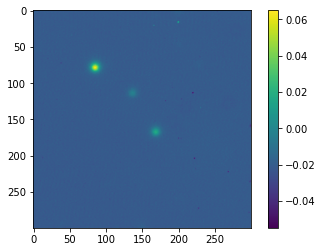

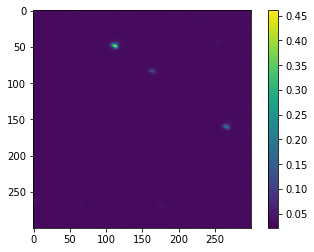

In [24]:
platescale = 0.184 # arcsec/pixel

plt.imshow(cutout.data[300:600, 300:600])
plt.colorbar()
plt.figure()
plt.imshow(cutout2.data[300:600, 300:600])
plt.colorbar()

### Night 1

(<matplotlib.patches.Circle at 0x7fbb98be9220>,)

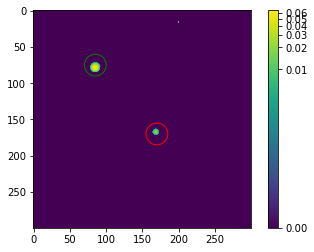

In [143]:
## Place aperture over Pluto (first night) -- eyeball it

apn1 = CircularAperture([170, 170], 15.)
apr1 = CircularAperture([85, 75], 15.)

norm = ImageNormalize(interval=ZScaleInterval(contrast=0.9), stretch=LogStretch(), vmin=0) 
plt.imshow(cutout.data[300:600, 300:600], norm=norm)
plt.colorbar()

apn1.plot(color='r')
apr1.plot(color='g')


Pluto night 1 coords [px]: 169.20493965366742 168.28260504963518


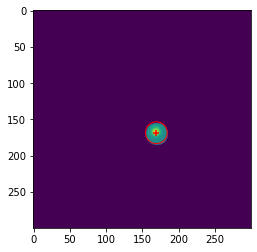

In [150]:
## Centroid aperture over Pluto (first night)

radius = 15.
xpos = apn1.positions[1]
ypos = apn1.positions[0]

x, y = np.ogrid[0:300, 0:300]

pmask1 = np.sqrt( (x-xpos)**2 + (y-ypos)**2 ) <= radius
isopluto1 = (cutout.data[300:600, 300:600] + np.abs(cutout.data[300:600, 300:600].min()))*pmask1

# plt.imshow(pmask1)

## Find centroid in window around pluto, place new aperture at centroid

x1, y1 = centroid_1dg(isopluto1**2)  # x, y = is the correct order
new_apn1 = CircularAperture([x1, y1], radius) # [x, y] is the correct order

plt.figure()
plt.imshow(isopluto1)
new_apn1.plot(color='r')
plt.scatter(x1, y1, marker='+', color='r')

print('Pluto night 1 coords [px]:', x1, y1)


(<matplotlib.patches.Circle at 0x7fbbb29b1040>,)

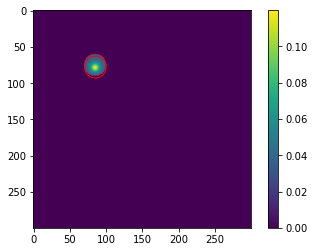

In [149]:
## Centroid over reference star

rmask1 = np.sqrt( (x-apr1.positions[1])**2 + (y-apr1.positions[0])**2 ) <= radius
isoref1 = (cutout.data[300:600, 300:600] + np.abs(cutout.data[300:600, 300:600].min()))*rmask1

## Find centroid in window around pluto, place new aperture at centroid

xr1, yr1 = centroid_1dg(isoref1**2)  # x, y = is the correct order
new_apr1 = CircularAperture([xr1, yr1], radius) # [x, y] is the correct order

plt.imshow(isoref1)
plt.colorbar()

new_apr1.plot(color='r')
apr1.plot(color='r', ls=':')


### Night 2

(<matplotlib.patches.Circle at 0x7fbba2383a60>,)

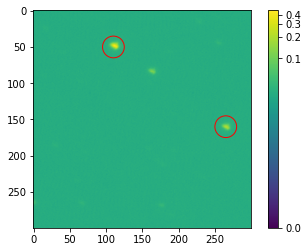

In [156]:
## Place aperture over Pluto (second night) -- eyeball it

apn2 = CircularAperture([265, 160], 15.)
apr2 = CircularAperture([110, 50], 15.)


norm = ImageNormalize(interval=ZScaleInterval(contrast=0.9), stretch=LogStretch(), vmin=0) 
plt.imshow(cutout2.data[300:600, 300:600], norm=norm)
plt.colorbar()

apn2.plot(color='r')
apr2.plot(color='r')


160.0 265.0
Pluto night 2 coords [px]: 265.6033809646092 160.08933184261596


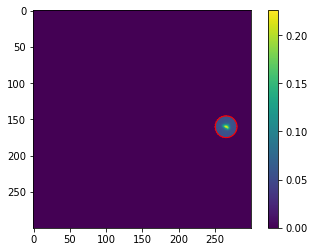

In [153]:
## Centroid aperture over Pluto (second night)

radius = 15.
xpos = apn2.positions[1]
ypos = apn2.positions[0]
print(xpos, ypos)

x, y = np.ogrid[0:300, 0:300]

pmask2 = np.sqrt( (x-xpos)**2 + (y-ypos)**2 ) <= radius
isopluto2 = (cutout2.data[300:600, 300:600] + np.abs(cutout2.data[300:600, 300:600].min()))*pmask2

# plt.imshow(pmask2)

## Find centroid in window around star, place new aperture at centroid

x2, y2 = centroid_1dg(isopluto2**2)  # x, y = is the correct order
new_apn2 = CircularAperture([x2, y2], radius) # [x, y] is the correct order

plt.imshow(isopluto2)
plt.colorbar()

new_apn2.plot(color='r')
apn2.plot(color='r', ls=':')

print('Pluto night 2 coords [px]:', x2, y2)

Ref star night 2 coords [px]: 112.35094945537429 48.68673476811644


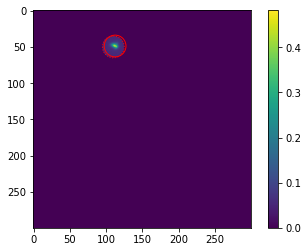

In [157]:
## Centroid aperture over ref star (second night)

rmask2 = np.sqrt( (x-apr2.positions[1])**2 + (y-apr2.positions[0])**2 ) <= radius
isoref2 = (cutout2.data[300:600, 300:600] + np.abs(cutout2.data[300:600, 300:600].min()))*rmask2


## Find centroid in window around star, place new aperture at centroid

xr2, yr2 = centroid_1dg(isoref2**2)  # x, y = is the correct order
new_apr2 = CircularAperture([xr2, yr2], radius) # [x, y] is the correct order

plt.imshow(isoref2)
plt.colorbar()

new_apr2.plot(color='r')
apr2.plot(color='r', ls=':')

print('Ref star night 2 coords [px]:', xr2, yr2)

### Math time

In [162]:
print('Pluto night 1 coords [px]:', x1, y1)
print('Pluto night 2 coords [px]:', x2, y2)

print('Ref star night 1 coords [px]:', xr1, yr1)
print('Ref star night 2 coords [px]:', xr2, yr2)

print('\nPIXELS')

d_x1 = np.abs(xr1 - x1)
d_y1 = np.abs(yr1 - y1)
print('Night 1:')
print('dx =', d_x1, 'dy =', d_y1)

d_x2 = np.abs(xr2 - x2)
d_y2 = np.abs(yr2 - y2)
print('Night 2:')
print('dx =', d_x2, 'dy =', d_y2)

d_xP = np.abs(d_x2 - d_x1)
d_yP = np.abs(d_y2 - d_y1)
print('Total Pluto motion:')
print('dx =', d_xP, 'dy =', d_yP, 'r=', np.sqrt(d_xP**2 + d_yP**2))

print('\nARCSECONDS')

print('Night 1:')
print('dx =', d_x1*platescale, 'dy =', d_y1*platescale)

print('Night 2:')
print('dx =', d_x2*platescale, 'dy =', d_y2*platescale)

print('Total Pluto motion:')
print('dx =', d_xP*platescale, 'dy =', d_yP*platescale, 'r=', 
      np.sqrt((d_xP*platescale)**2 + (d_yP*platescale)**2))

# dx = x2-x1
# dy = y2-y1
# dr = np.sqrt((x2-x1)**2 + (y2-y1)**2)

# print('delta x [px] =', dx)
# print('delta y [px] =', dy)
# print('delta r [px] =', dr)

# dr_arcsecs = dr*platescale

# print('delta x [asec] =', dx*platescale)
# print('delta y [asec] =', dy*platescale)

# print('delta r [arcseconds] =', dr_arcsecs)

Pluto night 1 coords [px]: 169.20493965366742 168.28260504963518
Pluto night 2 coords [px]: 265.6033809646092 160.08933184261596
Ref star night 1 coords [px]: 85.07865680365309 77.8124789336083
Ref star night 2 coords [px]: 112.35094945537429 48.68673476811644

PIXELS
Night 1:
dx = 84.12628285001433 dy = 90.47012611602688
Night 2:
dx = 153.2524315092349 dy = 111.40259707449952
Total Pluto motion:
dx = 69.12614865922056 dy = 20.93247095847265 r= 72.22598402849187

ARCSECONDS
Night 1:
dx = 15.479236044402636 dy = 16.646503205348946
Night 2:
dx = 28.19844739769922 dy = 20.498077861707912
Total Pluto motion:
dx = 12.719211353296583 dy = 3.8515746563589675 r= 13.289581061242501


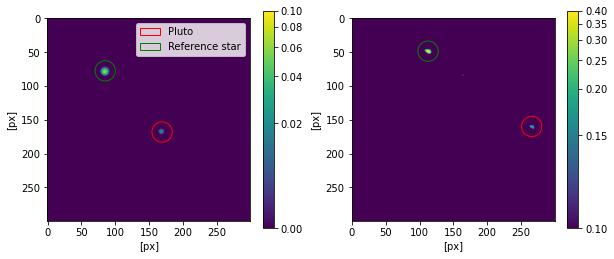

In [168]:
## Make a nice plot

fig, ax = plt.subplots(1,2, figsize=(10,4))

norm1 = ImageNormalize(interval=ZScaleInterval(contrast=0.9), stretch=AsinhStretch(), vmin=0, vmax=0.1) 
norm2 = ImageNormalize(interval=ZScaleInterval(contrast=0.9), stretch=AsinhStretch(), vmin=0.1, vmax=0.4) 

a = ax[0].imshow(cutout.data[300:600, 300:600], norm=norm1)
b = ax[1].imshow(cutout2.data[300:600, 300:600], norm=norm2)

# apn1.plot(axes=ax[0], color='r', ls=':', alpha=0.6)
new_apn1.plot(axes=ax[0], color='r', label='Pluto')
new_apr1.plot(axes=ax[0], color='g', label='Reference star')


# apn2.plot(axes=ax[1], color='r', ls=':', alpha=0.6)
new_apn2.plot(axes=ax[1], color='r', label='Pluto')
new_apr2.plot(axes=ax[1], color='g', label='Reference star')

plt.colorbar(mappable=a, ax=ax[0])
plt.colorbar(mappable=b, ax=ax[1])

ax[0].set_ylabel('[px]')
ax[0].set_xlabel('[px]')
ax[1].set_ylabel('[px]')
ax[1].set_xlabel('[px]')

ax[0].legend()